In [1]:
import paho.mqtt.client as mqtt
import time
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sys
import math
import statistics

In [2]:
# the buffer list for 3 slow QoS
slow_buffer_q0 = [] # buffer save the message got
slow_time_q0 = [] # buffer save the message time
slow_buffer_q1 = []
slow_time_q1 = []
slow_buffer_q2 = []
slow_time_q2 = []
# the 3 $SYS for slow QoS
slow_5min = [] # buffer save the SYS message
slow_time_5min =[] # buffer save the time
slow_count = []
slow_time_count =[]
slow_current = []# for current_size
slow_time_current = []
# the buffer list for 3 fast QoS
fast_buffer_q0 = []
fast_time_q0 = []
fast_buffer_q1 = []
fast_time_q1 = []
fast_buffer_q2 = []
fast_time_q2 = []
# the 3 $SYS for fast QoS
fast_5min = []
fast_time_5min = []
fast_count = []
fast_time_count = []
fast_current = []
fast_time_current = []

connect_time = 301

connecting functions

In [3]:
def slow_connect(client, userdata, flags, rc):
    print("Now connect with 3 $SYS/")#subscribe the $SYS for 5min,count & current
    client.subscribe("$SYS/broker/load/publish/sent/5min")
    client.subscribe("$SYS/broker/retained messages/count")
    client.subscribe("$SYS/broker/heap/current")
    print("Now connect with 3 slow QoS")#as professor said in disscussion form, can subscribe 3 QoS at 
                                        #one time with its QoS, to compare them with the same data and time
    client.subscribe("counter/slow/q0",0)# subscribe q0 with my QoS=0
    client.subscribe("counter/slow/q1",1)# subscribe q1 with my QoS=1
    client.subscribe("counter/slow/q2",2)# subscribe q2 with my QoS=2
def fast_connect(client, userdata, flags, rc):
    print("Now connect with 3 $SYS/")#subscribe the $SYS for 5min,count & current
    client.subscribe("$SYS/broker/load/publish/sent/5min")
    client.subscribe("$SYS/broker/retained messages/count")
    client.subscribe("$SYS/broker/heap/current")
    print("Now connect with 3 fast QoS")#as professor said in disscussion form, can subscribe 3 QoS at 
                                        #one time with its QoS, to compare them with the same data and time
    client.subscribe("counter/fast/q0",0)# subscribe q0 with my QoS=0
    client.subscribe("counter/fast/q1",1)# subscribe q1 with my QoS=1
    client.subscribe("counter/fast/q2",2)# subscribe q2 with my QoS=2

on messages part

In [4]:

def slow_message(client, userdata, msg):

    if msg.payload.hex() != "636c6f7365":#to avoid the "close" message
        if "counter/slow/q0"== msg.topic:#got q0 message
            slow_buffer_q0.append(str(msg.payload).split("'")[1])#translate from bytes to string to save
            slow_time_q0.append(msg.timestamp)#save the timestamp
        elif "counter/slow/q1"== msg.topic:#got q1 message
            slow_buffer_q1.append(str(msg.payload).split("'")[1])
            slow_time_q1.append(msg.timestamp)
        elif "counter/slow/q2"== msg.topic:#got q2 message
            slow_buffer_q2.append(str(msg.payload).split("'")[1])
            slow_time_q2.append(msg.timestamp)
        elif "$SYS/broker/load/publish/sent/5min"== msg.topic:#got SYS-5min
            slow_5min.append(str(msg.payload).split("'")[1])
            slow_time_5min.append(msg.timestamp)
        elif "$SYS/broker/retained messages/count"== msg.topic:#got SYS-count
            slow_count.append(str(msg.payload).split("'")[1])
            slow_time_count.append(msg.timestamp)
        elif "$SYS/broker/heap/current"== msg.topic:#got SYS-current_size
            slow_current.append(str(msg.payload).split("'")[1])
            slow_time_current.append(msg.timestamp)
        else: #this time got a null message
            print("Get nothing")
    else:# oh, got the "close"
        print("Got \"close\" on :"+ msg.topic)
        
def fast_message(client, userdata, msg):

    if msg.payload.hex() != "636c6f7365":
        if "counter/fast/q0"== msg.topic:
            fast_buffer_q0.append(str(msg.payload).split("'")[1])
            fast_time_q0.append(msg.timestamp)
        elif "counter/fast/q1"== msg.topic:
            fast_buffer_q1.append(str(msg.payload).split("'")[1])
            fast_time_q1.append(msg.timestamp)
        elif "counter/fast/q2"== msg.topic:
            fast_buffer_q2.append(str(msg.payload).split("'")[1])
            fast_time_q2.append(msg.timestamp)
        elif "$SYS/broker/load/publish/sent/5min"== msg.topic:
            fast_5min.append(str(msg.payload).split("'")[1])
            fast_time_5min.append(msg.timestamp)
        elif "$SYS/broker/retained messages/count"== msg.topic:
            fast_count.append(str(msg.payload).split("'")[1])
            fast_time_count.append(msg.timestamp)
        elif "$SYS/broker/heap/current"== msg.topic:
            fast_current.append(str(msg.payload).split("'")[1])
            fast_time_current.append(msg.timestamp)
        else:
            print("Get nothing")
    else:
        print("Got \"close\" on :"+ msg.topic)

calculate part

In [5]:

def report_results(buffer, time, connect_time):
    # something I need in this function
    buffer = list(map(int, buffer))#translate the string message to int
    gap_std=[]#save gap validation
    no_dup = sorted(set(buffer))#no duplicate total number
    no_dup_num = len(no_dup)
    ooo_num = 0
    loss_num = 0
    gap_num = 0
    gap = 0
    # Initialization result, if no message is received, return -1
    recieve_rate = -1
    loss_rate = -1
    duplicate_rate = -1
    ooo_rate = -1
    gap_mean = -1
    gap_variation = -1
    #AVG rate of recieve message
    rec_num = len(buffer)
    recieve_rate = round(rec_num/connect_time,5)
    
    # make a time gap list
    if len(buffer) != 0:# message is not null, else return -1
        for m in range(0,len(time)-1):
            if (buffer[m+1]-buffer[m] == 1) or (buffer[m+1]-buffer[m] == max(buffer)-min(buffer)):
                a = round((time[m+1]-time[m])*1000)#total gap time
                # calculate the time gap between packets
                gap_num +=1
                gap +=a
                gap_std.append(a)

            elif (buffer[m+1]-buffer[m] < 0) and (buffer[m+1]-buffer[m] != max(buffer)-min(buffer)):
                # calculate the ooo num
                ooo_num += 1
            elif buffer[m+1]-buffer[m] == 0:
                # if it is duplicate, let the last one's timestamp same as before to ignor the duplicate one 
                time[m+1] = time[m]

            if (buffer[m+1]-buffer[m] > 1) and (buffer[m+1]-buffer[m] != max(buffer)-min(buffer)):
                # calculate the loss
                loss_num += (buffer[m+1] - buffer[m] - 1)

        # calculate gap mean
        """
        gap mean: I think gap_mean is the total time/the total gap number
        """
        if gap_num>=1:#need got more than one message to count mean
            gap_mean = round(gap/gap_num, 5)
        else:# no enough messages
            gap_mean = "This time, not have any consecutive message"
            
        # calculate gap variation
        """
        gap_variation: Standard deviation of the mean
        """
        if len(gap_std)>=2:#need got more than two messages to count std
            gap_variation = round(statistics.stdev(gap_std), 5)
        else:#not enough
            gap_variation = "This time, not have more than 2 consecutive message"

        # loss rate
        """
        loss: I think loss = (the larger after the smaller) - (the smaller before the larger) - 1 
        and then got the mean of the total loss
        Idea comes from discussion forum https://wattlecourses.anu.edu.au/mod/forum/discuss.php?d=617211
        """
        loss_rate = round((loss_num)/(no_dup_num + loss_num), 5)

        # out of order rate
        """
        out of order rate: I think ooo = The current information is not less than 1 larger than the previous information.
        Ignore the smaller one after the larger one
        """
        ooo_rate = round((ooo_num)/(rec_num), 5)

        # duplicate rate
       """
       duplicate rate: the mean of the every duplicate rates in every 10s
       10s time piece: from the first message got, every 10s as a group got a little duplicate rate
       totally 300s = 30 groups
       """
        lim = time[0]
        dup_rate_total = 0
        dup_num = 0
    ## if you want to test any 10s to see a duplicate rate, plase tyr these codes    
#         for i in range(0, len(time)-1):# this can count any 10s value of dup but too slow, 1 fast will cost 6min to count in my PC
#             ten_s_buff = []
#             for j in range(0,len(time)-1-i):
#                 if time[i+j] <= lim+10:
#                     ten_s_buff.append(buffer[i+j])
#                 else:
#                     lim = time[i] + 10
#                     i = i - 1;
#                     ten_s_buff = []
#             whole_num = len(ten_s_buff)
#             dup_num = whole_num - len(set(ten_s_buff))
#             dup_rate_total += round((dup_num/whole_num),5)
#             k+=1
#         duplicate_rate= round(dup_rate_total/k, 5)
        ten_s_buff = []
        for i in range(0,len(time)-1):
            if time[i] <= lim+10:
                ten_s_buff.append(buffer[i])#memory the 10s little group 
            else:
                lim = time[i] + 10# change to the next 10s
                i = i - 1;
                ten_s_buff = []
            whole_num = len(ten_s_buff)
            if(whole_num>0):
                dup_num = whole_num - len(set(ten_s_buff))
                dup_rate_total += round((dup_num/whole_num),5)
        duplicate_rate= round(dup_rate_total/(connect_time/30), 5)

    
    # prtint and report the reults
    print('recieve rate: ', recieve_rate)
    print("loss rate:", loss_rate*100 , "%")    
    print("duplicate rate: ", duplicate_rate*100, "%")
    print("out of order rate:", ooo_rate*100 , "%")
    print("gap mean: ",gap_mean)
    print("gap variation: ",gap_variation)
    print("\n")
    return recieve_rate,loss_rate,duplicate_rate,ooo_rate,gap_mean,gap_variation

In [6]:
def report_plot(buffer, time, topic):# draw the line plot for every SYS topic I intrested
    buffer = list(map(float, buffer))
    plt.title(topic+'-time')
    plt.plot(time, buffer, "-.o", color='red',linewidth=2.0,)
    plt.xlabel("time")
    plt.ylabel(topic)
    plt.show()

In [7]:
# create the client_slow to connect all three slow QoS at one time and run for 5 min
client_slow = mqtt.Client(client_id='3310-u6693651', clean_session=True, userdata=None)
client_slow.username_pw_set(username='students', password='33106331')
client_slow.connect("comp3310.ddns.net")


client_slow.on_connect = slow_connect
client_slow.on_message = slow_message

startTime = datetime.datetime.now()

while True:
    client_slow.loop()
    elapsedTime = datetime.datetime.now() - startTime
    if elapsedTime.seconds > connect_time:
        client_slow.disconnect()# free my 3 QoS! not, will let the fast_client not work
        break

Now connect with 3 $SYS/
Now connect with 3 slow QoS


### SLOW-RESULT ###
    ****q0****
recieve rate:  1.0
loss rate: 0.0 %
duplicate rate:  0.0 %
out of order rate: 0.0 %
gap mean:  1001.58333
gap variation:  222.0461


    ****q1****
recieve rate:  0.99668
loss rate: 0.0 %
duplicate rate:  0.0 %
out of order rate: 0.0 %
gap mean:  1001.58194
gap variation:  222.3748


    ****q2****
recieve rate:  0.99668
loss rate: 0.0 %
duplicate rate:  0.0 %
out of order rate: 0.0 %
gap mean:  1001.60535
gap variation:  240.46733




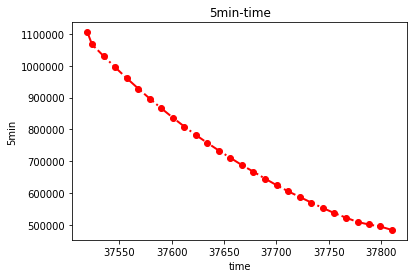

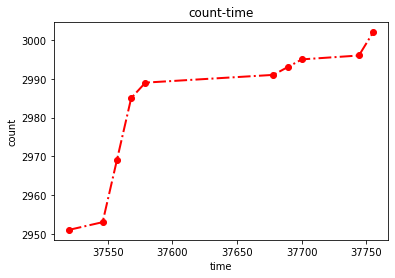

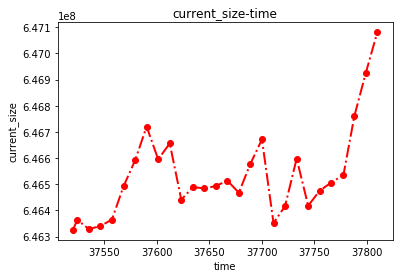

In [8]:
# slow-q0
print("### SLOW-RESULT ###")
print("    ****q0****")
rs1,ls1,ds1,os1,gms1,gvs1 = report_results(slow_buffer_q0, slow_time_q0, connect_time)

# slow-q1
print("    ****q1****")
rs2,ls2,ds2,os2,gms2,gvs2 = report_results(slow_buffer_q1, slow_time_q1, connect_time)

# slow-q2 
print("    ****q2****")
rs3,ls3,ds3,os3,gms3,gvs3 = report_results(slow_buffer_q2, slow_time_q2, connect_time)

# $SYS plots
report_plot(slow_5min,slow_time_5min,"5min")
report_plot(slow_count,slow_time_count,"count")
report_plot(slow_current,slow_time_current,"current_size")

In [9]:
# create the client_fast to connect all three slow QoS at one time and run for 5 min
client_fast = mqtt.Client(client_id='3310-u6693651', clean_session=True, userdata=None)
client_fast.username_pw_set(username='students', password='33106331')
client_fast.connect("comp3310.ddns.net")

client_fast.on_connect = fast_connect
client_fast.on_message = fast_message

startTime = datetime.datetime.now()

while True:
    client_fast.loop()
    elapsedTime = datetime.datetime.now() - startTime
    if elapsedTime.seconds > connect_time:
        client_fast.disconnect()
        break



Now connect with 3 $SYS/
Now connect with 3 fast QoS


### FAST-RESULT ###
    ****q0****
recieve rate:  93.60797
loss rate: 0.0 %
duplicate rate:  0.0 %
out of order rate: 0.0 %
gap mean:  10.60731
gap variation:  47.94278


    ****q1****
recieve rate:  14.7309
loss rate: 84.08099999999999 %
duplicate rate:  0.0 %
out of order rate: 0.0 %
gap mean:  61.26171
gap variation:  168.74412


    ****q2****
recieve rate:  13.06645
loss rate: 85.857 %
duplicate rate:  0.0 %
out of order rate: 0.0 %
gap mean:  71.25421
gap variation:  185.96439




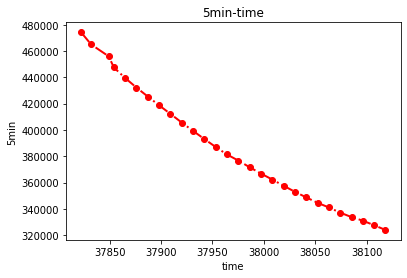

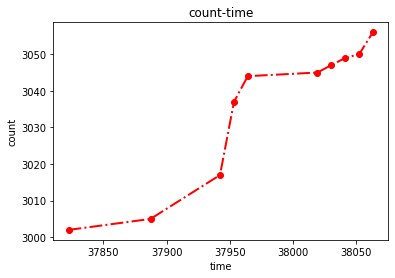

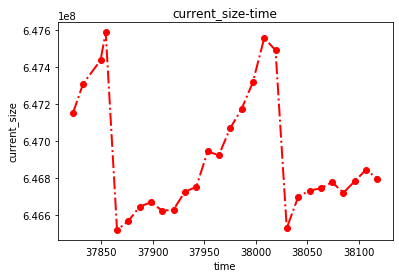

In [10]:
print("### FAST-RESULT ###")
print("    ****q0****")
rf1,lf1,df1,of1,gmf1,gvf1 = report_results(fast_buffer_q0, fast_time_q0, connect_time)

# slow/q1
print("    ****q1****")
rf2,lf2,df2,of2,gmf2,gvf2 = report_results(fast_buffer_q1, fast_time_q1, connect_time)

# slow/q2 
print("    ****q2****")
rf3,lf3,df3,of3,gmf3,gvf3 = report_results(fast_buffer_q2, fast_time_q2, connect_time)

# $SYS plots
report_plot(fast_5min,fast_time_5min,"5min")
report_plot(fast_count,fast_time_count,"count")
report_plot(fast_current,fast_time_current,"current_size")

In [11]:
client = mqtt.Client(client_id='3310-u6693651', clean_session=True, userdata=None,protocol=mqtt.MQTTv311, transport="tcp")
client.username_pw_set(username='students', password='33106331')
client.connect("comp3310.ddns.net")
client.loop_start()
# My computer's Qos=2 is not work, I don't know why, but qos=1 still ok here

client.publish("studentreport/u6693651/language","python 3.7.4 64-bit",qos=1,retain=True)
client.publish("studentreport/u6693651/network","wifi 3Mbps",qos=1,retain=True)
client.publish("studentreport/u6693651/location","ACT, Canberra, Australia",qos=1,retain=True)

client.publish("studentreport/u6693651/slow/0/recv",rs1,qos=1,retain=True)
client.publish("studentreport/u6693651/slow/0/loss",str(ls1*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/slow/0/dupe",str(ds1*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/slow/0/ooo",str(os1*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/slow/0/gap",gms1,qos=1,retain=True)
client.publish("studentreport/u6693651/slow/0/gvar",gvs1,qos=1,retain=True)

client.publish("studentreport/u6693651/slow/1/recv",rs2,qos=1,retain=True)
client.publish("studentreport/u6693651/slow/1/loss",str(ls2*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/slow/1/dupe",str(ds2*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/slow/1/ooo",str(os2*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/slow/1/gap",gms2,qos=1,retain=True)
client.publish("studentreport/u6693651/slow/1/gvar",gvs2,qos=1,retain=True)

client.publish("studentreport/u6693651/slow/2/recv",rs3,qos=1,retain=True)
client.publish("studentreport/u6693651/slow/2/loss",str(ls3*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/slow/2/dupe",str(ds3*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/slow/2/ooo",str(os3*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/slow/2/gap",gms3,qos=1,retain=True)
client.publish("studentreport/u6693651/slow/2/gvar",gvs3,qos=1,retain=True)

client.publish("studentreport/u6693651/fast/0/recv",rf1,qos=1,retain=True)
client.publish("studentreport/u6693651/fast/0/loss",str(lf1*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/fast/0/dupe",str(df1*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/fast/0/ooo",str(of1*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/fast/0/gap",gmf1,qos=1,retain=True)
client.publish("studentreport/u6693651/fast/0/gvar",gvf1,qos=1,retain=True)

client.publish("studentreport/u6693651/fast/1/recv",rf2,qos=1,retain=True)
client.publish("studentreport/u6693651/fast/1/loss",str(lf2*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/fast/1/dupe",str(df2*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/fast/1/ooo",str(of2*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/fast/1/gap",gmf2,qos=1,retain=True)
client.publish("studentreport/u6693651/fast/1/gvar",gvf2,qos=1,retain=True)

client.publish("studentreport/u6693651/fast/2/recv",rf3,qos=1,retain=True)
client.publish("studentreport/u6693651/fast/2/loss",str(lf3*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/fast/2/dupe",str(df3*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/fast/2/ooo",str(of3*100)+"%",qos=1,retain=True)
client.publish("studentreport/u6693651/fast/2/gap",gmf3,qos=1,retain=True)
client.publish("studentreport/u6693651/fast/2/gvar",gvf3,qos=1,retain=True)

time.sleep(10) # make sure the message can publish
client.loop_stop()
client.disconnect()
# all done!

0